<a href="https://colab.research.google.com/github/ApoorvaGrover/corrosion-estimation/blob/main/corrosion_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperparameter Tuning for Random Forest Model

## Hyperparameter Tuning for Neural Network Model (using Keras Tuner)

In [ ]:
!pip install keras-tuner -q

In [ ]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_nn_model(hp):
    model_tune = keras.Sequential()
    model_tune.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model_tune.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=128,
                                            step=32),
                                activation='relu'))

    model_tune.add(layers.Dense(1))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_tune.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                       loss='mae',
                       metrics=['mse'])
    return model_tune

# Instantiate the Keras Tuner (RandomSearch in this case)
tuner = kt.RandomSearch(
    build_nn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='corrosion_nn_tuning'
)

# Print a summary of the search space
tuner.search_space_summary()

# Run the hyperparameter search
tuner.search(X_train_scaled, y_train,
             epochs=50,  # Use fewer epochs for tuning to speed up
             validation_split=0.2,
             verbose=0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nOptimal number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Optimal units for layer {i}: {best_hps.get('units_' + str(i))}")
print(f"Optimal learning rate: {best_hps.get('learning_rate'):.1e}")

# Build the best model
best_nn_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best NN model
print("\nEvaluating the best Neural Network model:")
test_loss_best_nn, test_mse_best_nn = best_nn_model.evaluate(X_test_scaled, y_test)
print(f"Test MAE (mm) with best NN model: {test_loss_best_nn:.4f}")
print(f"Test MSE with best NN model: {test_mse_best_nn:.4f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
# We'll use the 'model' defined earlier, which is a RandomForestRegressor
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("\nBest parameters found:", grid_search.best_params_)
print("Best R² score found:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
print("R² Score with best Random Forest model:", r2_score(y_test, y_pred_best_rf))
print("Mean Absolute Error with best Random Forest model:", mean_absolute_error(y_test, y_pred_best_rf))

importing libraries and setting up

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')


In [ ]:
# ===============================================
# Part 2 - Create Synthetic Dataset
# ===============================================

np.random.seed(42)
n_samples = 500

data = pd.DataFrame({
    'time_years': np.random.uniform(0.1, 20, n_samples),
    'temperature_C': np.random.uniform(10, 80, n_samples),
    'humidity_%': np.random.uniform(30, 100, n_samples),
    'chloride_ppm': np.random.uniform(50, 1000, n_samples),
    'pH': np.random.uniform(5, 9, n_samples),
    'steel_grade': np.random.choice([1, 2, 3], n_samples)
})

# Nonlinear relationship (simulated)
data['corrosion_rate_mm_per_year'] = (
    0.02 * data['temperature_C']**0.5
    * (data['humidity_%'] / 100)
    * (data['chloride_ppm'] / 500)
    / (data['pH'])
    / (data['steel_grade'])
    + np.random.normal(0, 0.02, n_samples)
)

# Total thickness loss over time
data['thickness_loss_mm'] = data['corrosion_rate_mm_per_year'] * data['time_years']

print(data.head())


   time_years  temperature_C  humidity_%  chloride_ppm        pH  steel_grade  \
0    7.553348      58.871320   42.959305    543.127696  6.046823            3   
1   19.019215      47.526746   67.933066    505.222784  5.987915            3   
2   14.666679      31.666933   91.106209     74.359963  8.625018            3   
3   12.013304      66.965651   81.255742    374.185436  5.998185            3   
4    3.204771      57.931182   86.459280    411.185838  6.087799            3   

   corrosion_rate_mm_per_year  thickness_loss_mm  
0                   -0.009040          -0.068282  
1                    0.031695           0.602808  
2                    0.028981           0.425061  
3                   -0.006478          -0.077819  
4                   -0.031404          -0.100644  


In [ ]:
# ===============================================
# Part 3 - Split Data and Train Random Forest Model
# ===============================================

# Features and target
X = data[['time_years', 'temperature_C', 'humidity_%', 'chloride_ppm', 'pH', 'steel_grade']]
y = data['thickness_loss_mm']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("\nR² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))



R² Score: 0.17541428855159902
Mean Absolute Error: 0.15819013821966665


In [ ]:
# ===============================================
# Part 4 - Predict Corrosion & Estimate Lifetime
# ===============================================

# Define test conditions for one material
sample = pd.DataFrame({
    'time_years': np.arange(0, 25, 1),
    'temperature_C': 45,
    'humidity_%': 80,
    'chloride_ppm': 600,
    'pH': 6.5,
    'steel_grade': 2
})

# Predict thickness loss
sample['predicted_loss'] = model.predict(sample)

# Lifetime estimation
initial_thickness = 10   # mm
critical_thickness = 6   # mm
sample['remaining_thickness'] = initial_thickness - sample['predicted_loss']

# Find when critical thickness is reached
failure_time = sample.loc[sample['remaining_thickness'] <= critical_thickness, 'time_years']
if not failure_time.empty:
    estimated_life = failure_time.iloc[0]
else:
    estimated_life = ">25 years"

print(f"\nEstimated Lifetime: {estimated_life} years")



Estimated Lifetime: >25 years years


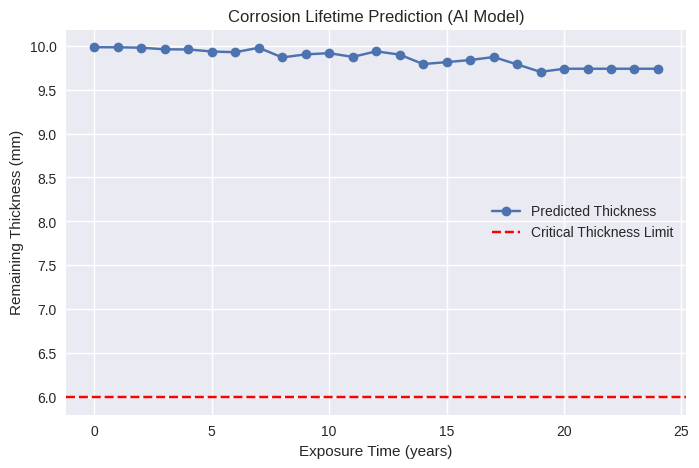

In [ ]:
# ===============================================
# Part 5 - Plot Remaining Thickness vs Time
# ===============================================

plt.figure(figsize=(8,5))
plt.plot(sample['time_years'], sample['remaining_thickness'], marker='o', label='Predicted Thickness')
plt.axhline(critical_thickness, color='r', linestyle='--', label='Critical Thickness Limit')
plt.title('Corrosion Lifetime Prediction (AI Model)')
plt.xlabel('Exposure Time (years)')
plt.ylabel('Remaining Thickness (mm)')
plt.legend()
plt.grid(True)
plt.show()


using tensorflow and keras

In [ ]:
# ===============================================
# 🧠 Part 6 - Neural Network for Corrosion Prediction
# ===============================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------------------------
# Split dataset again (X, y from earlier)
# -----------------------------------------------
X = data[['time_years', 'temperature_C', 'humidity_%', 'chloride_ppm', 'pH', 'steel_grade']]
y = data['thickness_loss_mm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------
# Normalize features (important for NN)
# -----------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------
# Define Neural Network Architecture
# -----------------------------------------------
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)   # output: thickness loss (mm)
])

# Compile model
model_nn.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mse']
)

# -----------------------------------------------
# Train the model
# -----------------------------------------------
history = model_nn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=16,
    verbose=1
)

# -----------------------------------------------
# Evaluate on test data
# -----------------------------------------------
test_loss, test_mse = model_nn.evaluate(X_test_scaled, y_test)
print(f"\nTest MAE (mm): {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2601 - mse: 0.1095 - val_loss: 0.2550 - val_mse: 0.1125
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1686 - mse: 0.0521 - val_loss: 0.2353 - val_mse: 0.1035
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1612 - mse: 0.0490 - val_loss: 0.2276 - val_mse: 0.0977
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1495 - mse: 0.0435 - val_loss: 0.2298 - val_mse: 0.1000
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1444 - mse: 0.0421 - val_loss: 0.2238 - val_mse: 0.0988
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1411 - mse: 0.0426 - val_loss: 0.2253 - val_mse: 0.0981
Epoch 7/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1494 - mse: 0.0440 - val_loss: 0.2253 - val_mse: 0.0973
Epoch 8/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1310 - mse: 0.0358 - val_loss: 0.2490 - val_mse: 0.1109
Epoch 9/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1548 - mse: 0.0440 - va

lifetime estimation

In [ ]:
# ===============================================
# Part 7 - Lifetime Estimation with NN
# ===============================================

# Create input for prediction (same as before)
sample = pd.DataFrame({
    'time_years': np.arange(0, 25, 1),
    'temperature_C': 45,
    'humidity_%': 80,
    'chloride_ppm': 600,
    'pH': 6.5,
    'steel_grade': 2
})

# Normalize sample using same scaler
sample_scaled = scaler.transform(sample)

# Predict thickness loss
sample['predicted_loss_nn'] = model_nn.predict(sample_scaled).flatten()

# Compute remaining thickness
initial_thickness = 10
critical_thickness = 6
sample['remaining_thickness_nn'] = initial_thickness - sample['predicted_loss_nn']

# Determine estimated lifetime
failure_time = sample.loc[sample['remaining_thickness_nn'] <= critical_thickness, 'time_years']
if not failure_time.empty:
    estimated_life_nn = failure_time.iloc[0]
else:
    estimated_life_nn = ">25 years"

print(f"\nEstimated Lifetime (Neural Network): {estimated_life_nn} years")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Estimated Lifetime (Neural Network): >25 years years


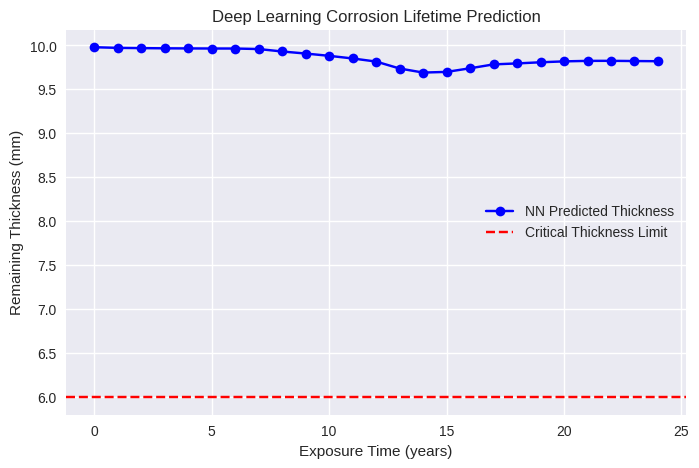

In [ ]:
# ===============================================
# Part 8 - Plot Neural Network Prediction
# ===============================================

plt.figure(figsize=(8,5))
plt.plot(sample['time_years'], sample['remaining_thickness_nn'], 'b-o', label='NN Predicted Thickness')
plt.axhline(critical_thickness, color='r', linestyle='--', label='Critical Thickness Limit')
plt.title('Deep Learning Corrosion Lifetime Prediction')
plt.xlabel('Exposure Time (years)')
plt.ylabel('Remaining Thickness (mm)')
plt.legend()
plt.grid(True)
plt.show()
